In [ ]:
# ==================================================================================
# NEURAL SHADOWS: Quantum phase classification using classical shadow tomography.
# ==================================================================================
from qutip import *
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from tqdm.auto import tqdm
import warnings
import os
import sys

# We suppress warnings for cleaner output during the run
warnings.filterwarnings("ignore")

# We utilize GPU acceleration if available for the Neural Network training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# -----------------------------------------------------------------------------
# 1. GLOBAL CONFIGURATION
# -----------------------------------------------------------------------------
N_SAMPLES = 250       # Dataset size
T_SNAPSHOTS = 25      # Snapshots
GAP_THRESHOLD = 0.1   # Phase boundary gap

In [ ]:
# -----------------------------------------------------------------------------
# 2. PHYSICS SIMULATION
# -----------------------------------------------------------------------------

def concurrence(rho):
    """We calculate the analytical concurrence to generate ground truth labels."""
    Y = Qobj([[0, -1j], [1j, 0]])
    R = rho * tensor(Y, Y) * rho.conj() * tensor(Y, Y)
    eigenvalues = np.sqrt(np.real(np.sort(R.eigenenergies())[::-1]))
    return max(0, eigenvalues[0] - sum(eigenvalues[1:]))

def werner_state_channel(rho, p):
    """We simulate the depolarizing channel acting on a Bell state."""
    I = qeye(rho.dims[0])
    d = rho.shape[0]
    return (1 - p) * rho + (p / d) * I

def generate_shadow_pair(rho, n_qubits, T):
    """
    We simulate the Classical Shadow protocol.
    Crucially, we perform joint measurements to preserve quantum correlations.
    """
    paulis = [sigmaz(), sigmax(), sigmay()]
    shadow_sample = np.zeros((T, n_qubits, 2), dtype=np.int8)

    projectors = []
    for op in paulis:
        projectors.append([(qeye(2) + op)/2, (qeye(2) - op)/2])

    for t in range(T):
        bases = np.random.randint(0, 3, size=n_qubits)
        b1, b2 = bases[0], bases[1]

        # We construct the joint projector for the two-qubit system
        P_joint = [
            tensor(projectors[b1][0], projectors[b2][0]),
            tensor(projectors[b1][0], projectors[b2][1]),
            tensor(projectors[b1][1], projectors[b2][0]),
            tensor(projectors[b1][1], projectors[b2][1])
        ]

        # We calculate Born probabilities and sample an outcome
        probs = np.array([(rho * P).tr().real for P in P_joint])
        probs = np.clip(probs, 0, 1)
        probs /= probs.sum()

        outcome_idx = np.random.choice(4, p=probs)
        outcomes = [[1,1], [1,-1], [-1,1], [-1,-1]][outcome_idx]

        shadow_sample[t, :, 0] = bases
        shadow_sample[t, :, 1] = outcomes

    return shadow_sample


# Shadow Dataset Generation
def generate_dataset(n_samples, t_snapshots, seed=None):
    """We generate a balanced dataset of entangled and separable states."""
    if seed is not None:
        np.random.seed(seed)

    X, y = [], []
    rho_init = ket2dm((tensor(basis(2,0), basis(2,0)) + tensor(basis(2,1), basis(2,1))).unit())

    # We over-generate slightly to account for the gap filter
    valid_count = 0
    attempts = 0
    max_attempts = n_samples * 5

    while valid_count < n_samples and attempts < max_attempts:
        p = np.random.uniform(0, 1)
        rho = werner_state_channel(rho_init, p)
        c = concurrence(rho)

        if c < 1e-5: label = 0
        elif c > GAP_THRESHOLD: label = 1
        else:
            attempts += 1
            continue

        X.append(generate_shadow_pair(rho, 2, t_snapshots))
        y.append(label)
        valid_count += 1
        attempts += 1

    return np.array(X), np.array(y)

In [ ]:
# -----------------------------------------------------------------------------
# 3. FEATURE EXTRACTION
# -----------------------------------------------------------------------------

def shadow_to_features(X_shadows):
    """
    We reconstruct the density matrix elements from the shadow samples.
    This creates the feature vector for our classical models.
    """
    N, T, n, _ = X_shadows.shape
    feats = np.zeros((N, 16))
    I2 = np.eye(2); Z = np.array([[1,0],[0,-1]])
    X = np.array([[0,1],[1,0]]); Y = np.array([[0,-1j],[1j,0]])

    def get_rho_snapshot(b, o):
        op = Z if b==0 else (X if b==1 else Y)
        return 3 * ((I2 + o*op)/2) - I2

    for i in range(N):
        acc = np.zeros((4,4), dtype=complex)
        for t in range(T):
            s = X_shadows[i, t]
            r1 = get_rho_snapshot(s[0,0], s[0,1])
            r2 = get_rho_snapshot(s[1,0], s[1,1])
            acc += np.kron(r1, r2)
        feats[i] = np.real(acc.flatten() / T)
    return feats

In [ ]:
# -----------------------------------------------------------------------------
# 4. MODEL DEFINITIONS
# -----------------------------------------------------------------------------

class QuantumFNN(nn.Module):
    """
    We define a compact Feedforward Neural Network for classification.
    """
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(16, 64), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1),  nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

def run_single_trial(verbose=True):
    """
    We encapsulate the entire training pipeline into a single function
    to facilitate Monte Carlo stability analysis.
    """
    # 1. Data Generation
    X_raw, y = generate_dataset(N_SAMPLES, T_SNAPSHOTS)
    X_feat = shadow_to_features(X_raw)

    # 2. Split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_feat, y, test_size=0.2, stratify=y)

    # 3. Logistic Regression
    lr = LogisticRegression(max_iter=2000, class_weight='balanced')
    lr.fit(X_tr, y_tr)
    lr_score = f1_score(y_te, lr.predict(X_te))

    # 4. Random Forest
    rf_params = {'n_estimators': [50, 100], 'max_depth': [None, 10], 'class_weight': ['balanced']}
    rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=3, scoring='f1')
    rf_grid.fit(X_tr, y_tr)
    rf_score = f1_score(y_te, rf_grid.predict(X_te))

    # 5. FNN
    t_X_tr = torch.tensor(X_tr, dtype=torch.float32).to(device)
    t_y_tr = torch.tensor(y_tr, dtype=torch.float32).unsqueeze(1).to(device)
    t_X_te = torch.tensor(X_te, dtype=torch.float32).to(device)

    fnn = QuantumFNN().to(device)
    opt = optim.Adam(fnn.parameters(), lr=0.001)
    crit = nn.BCELoss()

    fnn.train()
    for _ in range(300): # Silent training loop
        opt.zero_grad()
        loss = crit(fnn(t_X_tr), t_y_tr)
        loss.backward()
        opt.step()

    fnn.eval()
    with torch.no_grad():
        preds = (fnn(t_X_te) > 0.5).cpu().numpy().astype(int)
    fnn_score = f1_score(y_te, preds)

    # 6. SVM (RBF on Features)
    svm_params = {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 0.01, 0.1], 'class_weight': ['balanced']}
    svm_grid = GridSearchCV(SVC(kernel='rbf'), svm_params, cv=3, scoring='f1', n_jobs=-1)
    svm_grid.fit(X_tr, y_tr)
    svm_score = f1_score(y_te, svm_grid.predict(X_te))

    return lr_score, rf_score, fnn_score, svm_score, X_feat, y

--- Executing Representative Trial ---
Logistic Regression F1: 0.8308
Random Forest F1:       0.8286
FNN F1 Score:           0.8116
Shadow SVM F1:          0.8438
Dataset saved to 'quantum_shadow_dataset.csv'


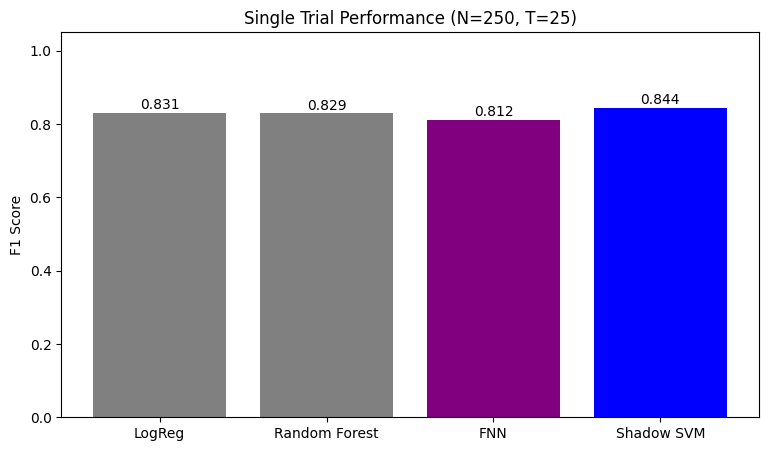

In [ ]:
# -----------------------------------------------------------------------------
# 5. EXPERIMENT EXECUTION (PART A: Representative Single Run)
# -----------------------------------------------------------------------------
print("--- Executing Representative Trial ---")
lr_s, rf_s, fnn_s, svm_s, X_final, y_final = run_single_trial()

print(f"Logistic Regression F1: {lr_s:.4f}")
print(f"Random Forest F1:       {rf_s:.4f}")
print(f"FNN F1 Score:           {fnn_s:.4f}")
print(f"Shadow SVM F1:          {svm_s:.4f}")

# We save the dataset from this representative run for the report
df = pd.DataFrame(X_final, columns=[f'feat_{i}' for i in range(16)])
df['label'] = y_final
df.to_csv('quantum_shadow_dataset.csv', index=False)
print("Dataset saved to 'quantum_shadow_dataset.csv'")

# Plot Part A
methods = ['LogReg', 'Random Forest', 'FNN', 'Shadow SVM']
scores = [lr_s, rf_s, fnn_s, svm_s]
colors = ['gray', 'gray', 'purple', 'blue']

plt.figure(figsize=(9, 5))
bars = plt.bar(methods, scores, color=colors)
plt.ylim(0, 1.05)
plt.ylabel('F1 Score')
plt.title(f'Single Trial Performance (N={N_SAMPLES}, T={T_SNAPSHOTS})')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{bar.get_height():.3f}", ha='center')
plt.savefig('single_trial_plot.png', dpi=1000)
plt.show()


--- Executing 100 Monte Carlo Trials for Stability Analysis ---


Monte Carlo Loop:   0%|                                                     | 0/100 [00:00<?, ?it/s]


--- Aggregated Statistics (Mean ± Std) ---
Logistic Regression: 0.802 ± 0.049
Random Forest:       0.820 ± 0.044
FNN:                 0.814 ± 0.048
Shadow SVM:          0.799 ± 0.053


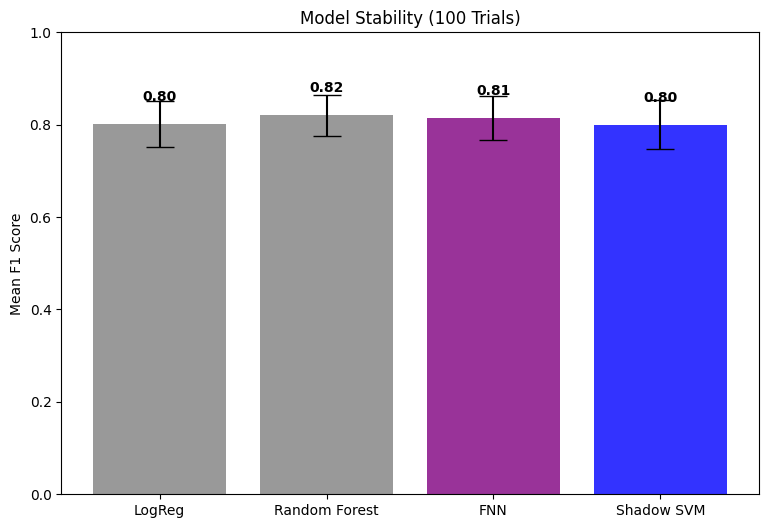

In [ ]:
# -----------------------------------------------------------------------------
# 5. EXPERIMENT EXECUTION (PART B: Monte Carlo Stability Analysis)
# -----------------------------------------------------------------------------

NUM_TRIALS = 100
print(f"\n--- Executing {NUM_TRIALS} Monte Carlo Trials for Stability Analysis ---")

results = {'LR': [], 'RF': [], 'FNN': [], 'SVM': []}

# We use a progress bar to track the 100 trials
for i in tqdm(range(NUM_TRIALS), desc="Monte Carlo Loop", ncols=100, leave=True, file=sys.stdout):
    # We run the trial without fixed seeds to capture true variance
    lr, rf, fnn, svm, _, _ = run_single_trial()
    results['LR'].append(lr)
    results['RF'].append(rf)
    results['FNN'].append(fnn)
    results['SVM'].append(svm)

# Calculate Statistics
means = [np.mean(results['LR']), np.mean(results['RF']), np.mean(results['FNN']), np.mean(results['SVM'])]
stds = [np.std(results['LR']), np.std(results['RF']), np.std(results['FNN']), np.std(results['SVM'])]

print("\n--- Aggregated Statistics (Mean ± Std) ---")
print(f"Logistic Regression: {means[0]:.3f} ± {stds[0]:.3f}")
print(f"Random Forest:       {means[1]:.3f} ± {stds[1]:.3f}")
print(f"FNN:                 {means[2]:.3f} ± {stds[2]:.3f}")
print(f"Shadow SVM:          {means[3]:.3f} ± {stds[3]:.3f}")

# Plot Part B (Error Bars)
plt.figure(figsize=(9, 6))
bars = plt.bar(methods, means, yerr=stds, capsize=10, color=colors, alpha=0.8)
plt.ylim(0, 1.0)
plt.ylabel('Mean F1 Score')
plt.title(f'Model Stability ({NUM_TRIALS} Trials)')
for i, v in enumerate(means):
    plt.text(i, v + 0.05, f"{v:.2f}", ha='center', fontweight='bold')
plt.savefig('stability_analysis_plot.png', dpi=1000)
plt.show()